In [9]:
# Usage guide:

# This document is not kept on record. If the calcualtions are to be kept,
# copy the whole notebook and put it in "quick_calculations" or appropriate
# folders.

In [10]:
# import all the E9 stuff
import logging
import numpy as np
import matplotlib.pyplot as plt
import sys
from pathlib import Path

# User defined modules
E9path = Path("C:/", "Users", "ken92", "Documents", "Studies", "E5", "simulation", "E9_simulations")
if str(E9path) not in sys.path:
    sys.path.insert(1, str(E9path))
import E9_fn.E9_constants as E9c
import E9_fn.E9_atom as E9a
import E9_fn.E9_cooltrap as E9ct
import E9_fn.thermodynamics as thmdy
# import E9_fn.polarizabilities_calculation as E9pol
# import E9_fn.datasets.transition_line_data as TLData
from E9_fn import util

# Logging
logpath = '' # '' if not logging to a file
loglevel = logging.INFO
logroot = logging.getLogger()
list(map(logroot.removeHandler, logroot.handlers))
list(map(logroot.removeFilter, logroot.filters))
logging.basicConfig(filename = logpath, level = loglevel)

In [11]:
E_range = (0, 2)
N_states_dispersive = 6000
DoS_fn = util.kagome_DoS

In [12]:
N_states_flat = N_states_dispersive // 2
N_states = N_states_dispersive + N_states_flat

E_orbs_dispersive = thmdy.E_orbs_from_DoS(DoS_fn, E_range, N_states_dispersive)
E_orbs_flat = np.ones(N_states_flat) * E_range[1]
E_orbs_kagome = np.concatenate((E_orbs_dispersive, E_orbs_flat))
E_orbs_linear = np.linspace(0, E_range[1], N_states)

E_avg_T_infty_kagome = E_orbs_kagome.mean()
E_avg_T_infty_linear = E_orbs_linear.mean()

Text(0.5, 0.98, 'Number of particles in kagome lattice vs chemical potential\n')

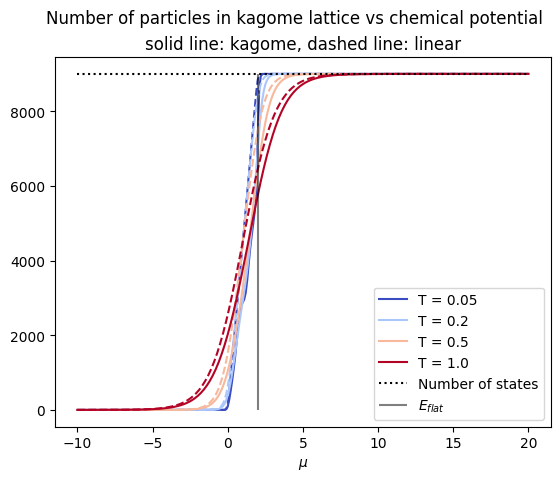

In [ ]:
T_scan_mu = np.array([0.05, 0.2, 0.5, 1])
mu_range = np.linspace(-10, 20, 301)
fig_N_tot_mu, ax_N_tot_mu = util.make_simple_axes()
cmap = plt.get_cmap('coolwarm')

for T_sys in T_scan_mu:
    color = util.get_color(T_sys, T_scan_mu, cmap, assignment = "index")
    N_particles_kagome = np.sum(util.fermi_stat(E_orbs_kagome[:, np.newaxis], T_sys, mu_range[np.newaxis, :]), axis = 0)
    N_particles_linear = np.sum(util.fermi_stat(E_orbs_linear[:, np.newaxis], T_sys, mu_range[np.newaxis, :]), axis = 0)

    ax_N_tot_mu.plot(mu_range, N_particles_kagome, label = f'T = {T_sys}', color = color)
    ax_N_tot_mu.plot(mu_range, N_particles_linear, color = color, linestyle = '--')
ax_N_tot_mu.hlines(N_states, mu_range[0], mu_range[-1], color = 'k', linestyle = ':', label = 'Number of states')
ax_N_tot_mu.vlines(E_range[1], 0, N_states, color = 'k', alpha = 0.5, linestyle = '-', label = r'$E_{flat}$')
ax_N_tot_mu.set_xlabel(r'$\mu$')
ax_N_tot_mu.legend(loc = 'lower right')
ax_N_tot_mu.set_title(f'solid line: kagome, dashed line: linear')
fig_N_tot_mu.suptitle(f'Number of particles in kagome lattice vs chemical potential\n')

Text(0.5, 0.98, 'solid line: kagome, dashed line: linear')

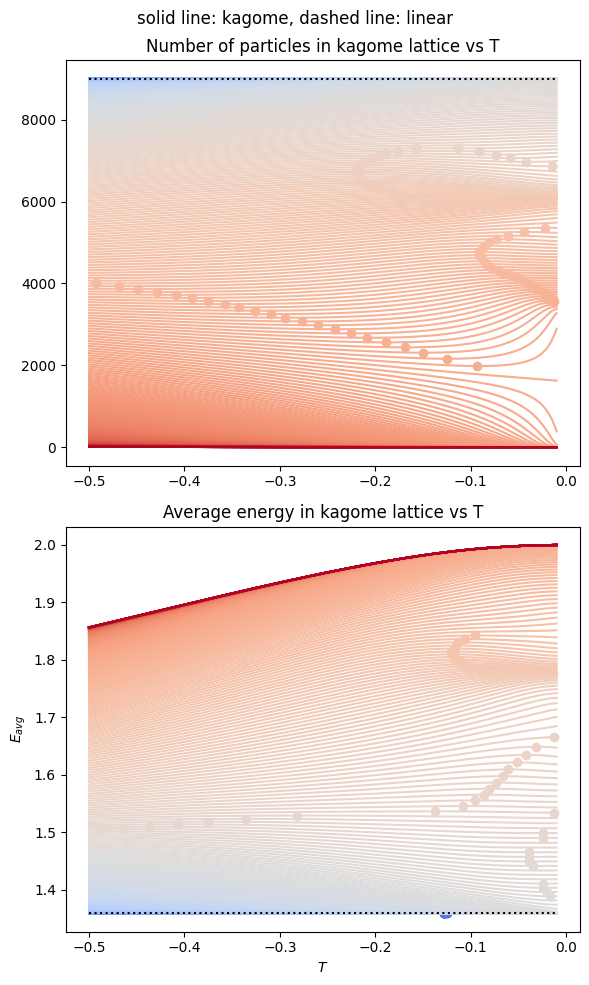

In [22]:
# mu_scan_T = np.array([-2, 0, 2, 5, 10])
mu_scan_T = np.linspace(-5, 5, 501)
# T_range = np.linspace(-5, 5, 501)
T_range = np.linspace(-0.5, -0.01, 201)
fig_N_tot_T = plt.figure(figsize = (6, 10), tight_layout = True)
ax_N_tot_T = fig_N_tot_T.add_subplot(2, 1, 1)
ax_E_avg_T = fig_N_tot_T.add_subplot(2, 1, 2)
cmap = plt.get_cmap('coolwarm')
flag_plot_linear = False

for mu_sys in mu_scan_T:
    color = get_color(mu_sys, mu_scan_T, cmap, assignment = "value")
    filling_factor_kagome = util.fermi_stat(E_orbs_kagome[:, np.newaxis], T_range[np.newaxis, :], mu_sys)
    N_particles_kagome = np.sum(filling_factor_kagome, axis = 0)
    E_avg_T_kagome = E_orbs_kagome @ filling_factor_kagome / N_particles_kagome
    inflection_pts_N = util.find_sign_change(util.find_derivative(N_particles_kagome))
    inflection_pts_E = util.find_sign_change(util.find_derivative(E_avg_T_kagome))

    ax_N_tot_T.plot(T_range, N_particles_kagome, color = color)
    ax_N_tot_T.scatter(T_range[inflection_pts_N], N_particles_kagome[inflection_pts_N], color = color, marker = 'o')
    ax_E_avg_T.plot(T_range, E_avg_T_kagome, color = color, linestyle = '-', label = f'mu = {mu_sys}')
    ax_E_avg_T.scatter(T_range[inflection_pts_E], E_avg_T_kagome[inflection_pts_E], color = color, marker = 'o')
    
    if flag_plot_linear:
        filling_factor_linear = util.fermi_stat(E_orbs_linear[:, np.newaxis], T_range[np.newaxis, :], mu_sys)
        N_particles_linear = np.sum(filling_factor_linear, axis = 0)
        E_avg_T_linear = E_orbs_linear @ filling_factor_linear / N_particles_linear

        ax_N_tot_T.plot(T_range, N_particles_linear, color = color, linestyle = '--')
        ax_E_avg_T.plot(T_range, E_avg_T_linear, color = color, linestyle = '--')

ax_N_tot_T.hlines(N_states, T_range[0], T_range[-1], color = 'k', linestyle = ':', label = 'Number of states')
ax_N_tot_T.set_title(f'Number of particles in kagome lattice vs T')
# ax_N_tot_T.legend(loc = 'best')

ax_E_avg_T.hlines(E_avg_T_infty_kagome, T_range[0], T_range[-1], color = 'k', linestyle = ':', label = r'$E_{avg}^{T \to \infty}$ kagome')
if flag_plot_linear: ax_E_avg_T.hlines(E_avg_T_infty_linear, T_range[0], T_range[-1], color = 'k', linestyle = '--', label = r'$E_{avg}^{T \to \infty}$ linear')
# ax_E_avg_T.legend(loc = 'best')
ax_E_avg_T.set_title(f'Average energy in kagome lattice vs T')
ax_E_avg_T.set_ylabel(r"$E_{avg}$")
ax_E_avg_T.set_xlabel(r'$T$')
fig_N_tot_T.suptitle(f'solid line: kagome, dashed line: linear')

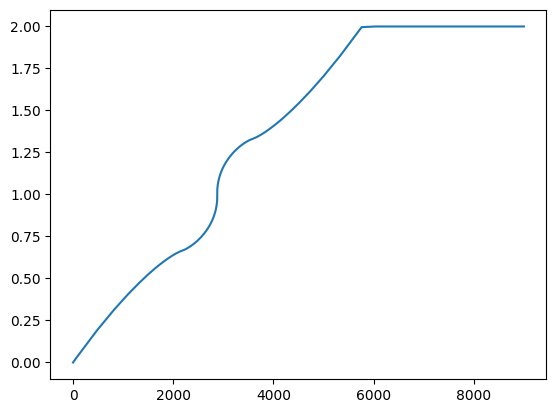

In [16]:
plt.plot(E_orbs_kagome)